# Общие подсчеты

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.power import tt_ind_solve_power, zt_ind_solve_power
from statsmodels.stats import proportion
from statsmodels.stats.meta_analysis import effectsize_smd

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

## Работа с датасетом

In [3]:
df = pd.read_csv('access_log_202406061530.csv',sep=';')
df

,dt,tme,host,uri,uuid,http_referer
0,2024-03-11,2024-03-11 02:24:05,www.drom.ru,/reviews/mazda/,2DFFCEFAE7058EADEC2146CC6909D61F9,NaN
1,2024-03-11,2024-03-11 08:32:45,www.drom.ru,/reviews/mazda/,AF07979ACDDE0FB05AC0BA043618C1C01,NaN
2,2024-03-11,2024-03-10 14:21:12,www.drom.ru,/reviews/,B09421E2D5E29714C394D2408D0DF9FE1,NaN
3,2024-03-11,2024-03-10 22:34:45,www.drom.ru,/reviews/mazda/,17D10C2F9AA72622A403E5BFB5EAA7556,NaN
4,2024-03-11,2024-03-11 05:35:15,www.drom.ru,/reviews/toyota/,5966060A2DE813BA4F89F6BD935A94717,NaN
...,...,...,...,...,...,...
226177,2024-03-22,2024-03-22 08:58:23,www.drom.ru,/reviews/mazda/,E192F5E74CB3D84D7C33F379E710F49E3,NaN
226178,2024-03-22,2024-03-21 18:53:44,www.drom.ru,/reviews/lexus/,F3028CCAE63D57FB9B1A64497678E2942,https://www.google.com/
226179,2024-03-22,2024-03-22 01:46:43,www.drom.ru,/reviews/mazda/,7A85E679791B520B10F9B02FB7FD3A8B5,NaN
226180,2024-03-22,2024-03-22 09:11:23,www.drom.ru,/reviews/mazda/,11BAEC40C54F7363EDF00FAD09F90D303,NaN


In [4]:
sorted(df.dt.unique()) 
# эксперимент шел 1 неделю, 11-17 числа, другие убрать(?)

['2024-03-11',
 '2024-03-12',
 '2024-03-13',
 '2024-03-14',
 '2024-03-15',
 '2024-03-16',
 '2024-03-17',
 '2024-03-18',
 '2024-03-19',
 '2024-03-20',
 '2024-03-21',
 '2024-03-22']

In [5]:
df = df[df.dt <= '2024-03-17']
df.tail()

,dt,tme,host,uri,uuid,http_referer
214826,2024-03-14,2024-03-13 17:02:35,www.drom.ru,/reviews/moskvitch/,00DD5ED339260D8DA125A8D4405654080,https://www.drom.ru/reviews/
214831,2024-03-14,2024-03-13 14:46:49,www.drom.ru,/reviews/mazda/,B113F0B3E6457163BBB90CA5B28A689E8,NaN
214839,2024-03-14,2024-03-13 15:40:59,www.drom.ru,/reviews/toyota/,D3BA2E143DA0D866C85BD140A8CDCD620,NaN
214840,2024-03-14,2024-03-14 00:38:40,www.drom.ru,/reviews/toyota/,C726B5A4822236D345F48099A85A76258,NaN
214846,2024-03-14,2024-03-13 18:37:07,www.drom.ru,/reviews/,0C30AB121610E92EA218004A17A55F069,https://www.drom.ru/reviews/hongqi/e-hs9/


In [6]:
df['group'] = df['uuid'].apply(lambda x: 'A' if int(x[-1])%2 == 0 else 'B')
df.head()

,dt,tme,host,uri,uuid,http_referer,group
0,2024-03-11,2024-03-11 02:24:05,www.drom.ru,/reviews/mazda/,2DFFCEFAE7058EADEC2146CC6909D61F9,NaN,B
1,2024-03-11,2024-03-11 08:32:45,www.drom.ru,/reviews/mazda/,AF07979ACDDE0FB05AC0BA043618C1C01,NaN,B
2,2024-03-11,2024-03-10 14:21:12,www.drom.ru,/reviews/,B09421E2D5E29714C394D2408D0DF9FE1,NaN,B
3,2024-03-11,2024-03-10 22:34:45,www.drom.ru,/reviews/mazda/,17D10C2F9AA72622A403E5BFB5EAA7556,NaN,A
4,2024-03-11,2024-03-11 05:35:15,www.drom.ru,/reviews/toyota/,5966060A2DE813BA4F89F6BD935A94717,NaN,B


In [7]:
# число юзеров в выборке
df.groupby('group')['uuid'].nunique()

group
A    40239
B    39829
Name: uuid, dtype: int64

## Работа с посещаемостью раздела с отзывами

In [37]:
# число посещений всего
df.groupby('group')['uri'].count()

group
A    65949
B    67037
Name: uri, dtype: int64

In [40]:
visits.groupby('group')['uri'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,40239.0,1.638932,2.881048,1.0,1.0,1.0,1.0,293.0
B,39829.0,1.683120,3.896199,1.0,1.0,1.0,1.0,319.0


In [41]:

def group_percentiles(df, group_col, value_col, percentiles=[i*0.1 for i in range(10)]+[0.95,0.99,0.996]):
    """
    Вычисляет процентильные значения для каждой группы в DataFrame.

    :param df: pandas DataFrame с данными
    :param group_col: название колонки с группами
    :param value_col: название колонки со значениями
    :param percentiles: список процентилей, которые нужно вычислить (значения от 0 до 1)
    :return: DataFrame с процентильными значениями для каждой группы
    """
    grouped = df.groupby(group_col)[value_col].quantile(percentiles).unstack(level=1)
    grouped.columns = [f'{int(p*100)}%' for p in grouped.columns]
    return grouped

percentiles_df = group_percentiles(visits, 'group', 'uri')
percentiles_df

,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,99%
group,,,,,,,,,,,,,
A,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,11.62,18.0
B,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,4.0,11.00,19.0


видно перекос в данных, построим распределение

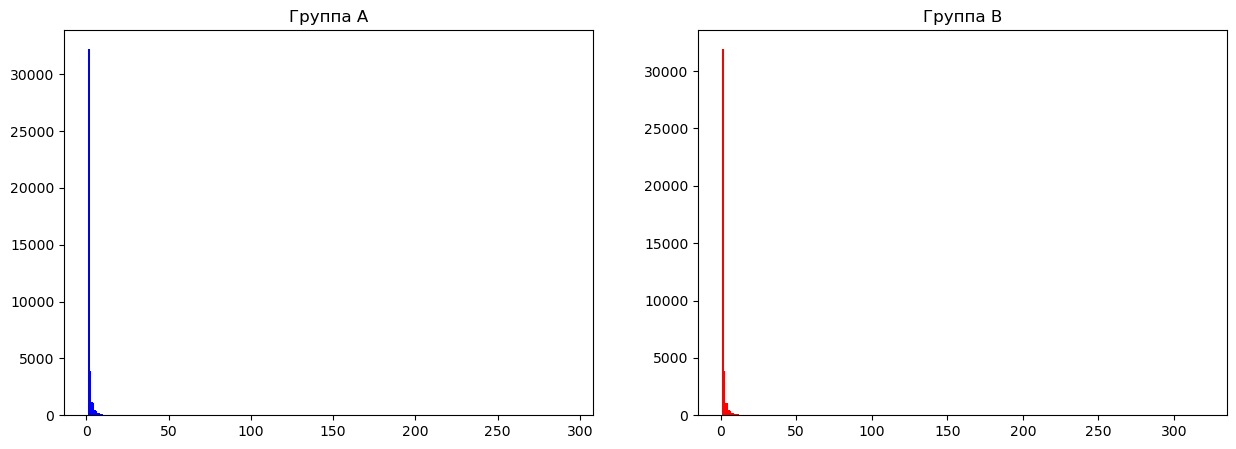

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=False)
axs[0].hist(visits[visits['group'] == 'A']['uri'], bins=319, density=False, alpha=1, color='blue')
axs[0].set_title('Группа А')
axs[1].hist(visits[visits['group'] == 'B']['uri'], bins=319, density=False, alpha=1, color='red');
axs[1].set_title('Группа B');


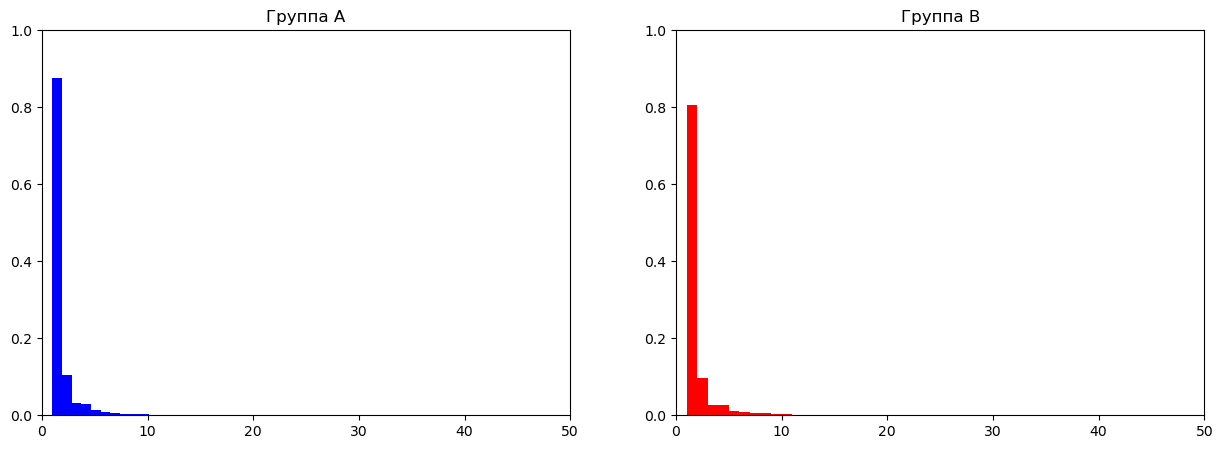

In [43]:
# сократим масштаб до 50
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(visits[visits['group'] == 'A']['uri'], bins=319, density=True, alpha=1, color='blue')
axs[0].set_title('Группа А')
axs[0].set_xlim(0,50)
axs[0].set_ylim(0,1)
axs[1].hist(visits[visits['group'] == 'B']['uri'], bins=319, density=True, alpha=1, color='red');
axs[1].set_title('Группа B')
axs[1].set_xlim(0,50)
axs[1].set_ylim(0,1);

In [44]:
pd.set_option('display.max_rows', None)
visits.groupby('group')['uri'].value_counts(normalize=True).sort_index().cumsum()

group  uri
A      1      0.801287
       2      0.897860
       3      0.926564
       4      0.953055
       5      0.965307
       6      0.974030
       7      0.979448
       8      0.983573
       9      0.986282
       10     0.988519
       11     0.989985
       12     0.991451
       13     0.992917
       14     0.993762
       15     0.994533
       16     0.995253
       17     0.995825
       18     0.996297
       19     0.996744
       20     0.997217
       21     0.997540
       22     0.997813
       23     0.998037
       24     0.998136
       25     0.998285
       26     0.998410
       27     0.998608
       28     0.998882
       29     0.998981
       30     0.999031
       31     0.999056
       32     0.999080
       33     0.999105
       34     0.999180
       35     0.999205
       36     0.999279
       37     0.999329
       38     0.999379
       39     0.999404
       41     0.999453
       43     0.999503
       45     0.999528
       46     0.999553


In [45]:
pd.reset_option('display.max_rows', None)

Более 99.5% юзеров обеих групп посещали страницу менее 20 раз, в логах имеются выбросы, 
которые могут повлиять на выводы в тесте
Рассмотрим два варианта статистических тестов:

1) Непараметрический тест Манна-Уитни

In [46]:
grA = visits[visits['group'] == 'A']['uri']
grB = visits[visits['group'] == 'B']['uri']
stats.mannwhitneyu(grA, grB, alternative='less')

MannwhitneyuResult(statistic=802179996.5, pvalue=0.6441508240510514)

p-значение: 0.6441508240510514 (что значительно больше типичного уровня значимости, например, 0.05)
Вывод
Поскольку p-значение значительно больше 0.05, у нас нет оснований отвергнуть нулевую гипотезу 
Это означает, что мы не обнаружили статистически значимой разницы, указывающей на то, что группа A имеет меньшее число посещений, чем группа B.

2) T-test
Предварительно удалим выбросы(более 20 посещений)

In [47]:
visits_20 = visits[visits.uri <= 20]
visits_20

,group,uuid,uri
0,A,0006751C7CBBB65C40FBB7C19B42ABFB4,1
1,A,00082754B6C25321F1AF03A8CD3811222,1
2,A,0008CE7100C235E79E1E9B15B9B706AA2,1
3,A,00096FDD7B9DC65A942DD1D28D2D40896,1
4,A,000C64B305937CEDC4CFC5FB02A74E552,1
...,...,...,...
80063,B,FFF95CA3F522049BEA99B3980C16D4DF7,1
80064,B,FFF96C36444C309EC563DC972496D4727,1
80065,B,FFFDEFC6637D4A8599D893EE835378459,1
80066,B,FFFF38677E524833D7AE9E02C89F0FEF1,1


In [71]:
# число юзеров в выборке
visits_20.groupby('group')['uuid'].count()

group
A    40127
B    39687
Name: uuid, dtype: int64

In [72]:
visits_20.groupby('group')['uri'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,40127.0,1.545942,1.707598,1.0,1.0,1.0,1.0,20.0
B,39687.0,1.535188,1.668523,1.0,1.0,1.0,1.0,20.0


In [50]:
mean_A = 1.545942
mean_B = 1.535188
std_A = 1.707598
std_B = 1.668523
n_A = 40127
n_B = 39687
var_A = std_A ** 2
var_B = std_B ** 2

In [51]:
t_stat = (mean_A - mean_B) / ((var_A / n_A + var_B / n_B) ** 0.5)
n = ((var_A / n_A + var_B / n_B) ** 2) / ((var_A ** 2 / (n_A ** 2 * (n_A - 1))) + (var_B ** 2 / (n_B ** 2 * (n_B - 1))))
p_value = 2 * stats.t.sf(abs(t_stat), n)
print(f"t-statistic: {t_stat}, degrees of freedom: {n}, p-value: {p_value}")

t-statistic: 0.8998779073316777, degrees of freedom: 79800.27502383929, p-value: 0.36818794383272524


In [67]:
grA = visits_20[visits_20['group'] == 'A']['uri']
grB = visits_20[visits_20['group'] == 'B']['uri']
t_stat, p_value = stats.ttest_ind(grA,grB,equal_var=False)
if t_stat < 0:
    one_sided_p_value = p_value / 2
else:
    one_sided_p_value = 1 - p_value / 2

print(f"t-статистика: {t_stat}, одностороннее p-значение: {one_sided_p_value}")

t-статистика: 0.899860303815776, одностороннее p-значение: 0.8159013435247351


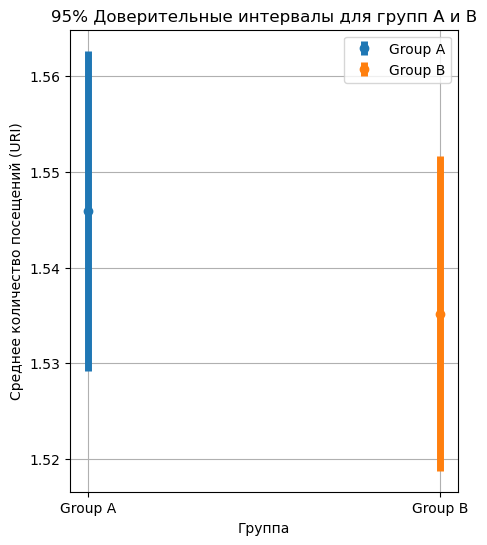

In [69]:
confidence_level = 0.95
grA_mean = np.mean(grA)
grB_mean = np.mean(grB)
grA_sem = stats.sem(grA)
grB_sem = stats.sem(grB)

grA_ci = stats.t.interval(confidence_level, len(grA)-1, loc=grA_mean, scale=grA_sem)
grB_ci = stats.t.interval(confidence_level, len(grB)-1, loc=grB_mean, scale=grB_sem)

# Построение графиков доверительных интервалов
plt.figure(figsize=(5, 6))

# Группа A
plt.errorbar(x=0, y=grA_mean, yerr=[[grA_mean - grA_ci[0]], [grA_ci[1] - grA_mean]], fmt='o', label='Group A',elinewidth=5)

# Группа B
plt.errorbar(x=1, y=grB_mean, yerr=[[grB_mean - grB_ci[0]], [grB_ci[1] - grB_mean]], fmt='o', label='Group B',elinewidth=5)

# Настройка графика
plt.xticks([0, 1], ['Group A', 'Group B'])
plt.title('95% Доверительные интервалы для групп A и B')
plt.xlabel('Группа')
plt.ylabel('Среднее количество посещений (URI)')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
grA = visits[visits['group'] == 'A']['uri']
grB = visits[visits['group'] == 'B']['uri']
t_stat, p_value = stats.ttest_ind(grA,grB,equal_var=False)
if t_stat < 0:
    one_sided_p_value = p_value / 2
else:
    one_sided_p_value = 1 - p_value / 2

print(f"t-статистика: {t_stat}, одностороннее p-значение: {one_sided_p_value}")

t-статистика: -1.8231848443841439, одностороннее p-значение: 0.034139734172496695


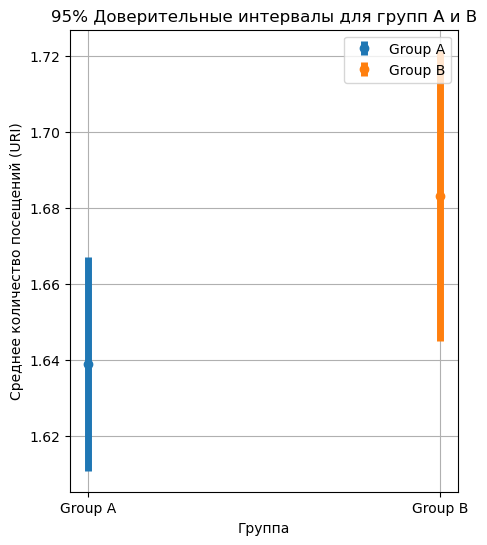

In [66]:
confidence_level = 0.95
grA_mean = np.mean(grA)
grB_mean = np.mean(grB)
grA_sem = stats.sem(grA)
grB_sem = stats.sem(grB)

grA_ci = stats.t.interval(confidence_level, len(grA)-1, loc=grA_mean, scale=grA_sem)
grB_ci = stats.t.interval(confidence_level, len(grB)-1, loc=grB_mean, scale=grB_sem)

# Построение графиков доверительных интервалов
plt.figure(figsize=(5, 6))

# Группа A
plt.errorbar(x=0, y=grA_mean, yerr=[[grA_mean - grA_ci[0]], [grA_ci[1] - grA_mean]], fmt='o', label='Group A',elinewidth=5)

# Группа B
plt.errorbar(x=1, y=grB_mean, yerr=[[grB_mean - grB_ci[0]], [grB_ci[1] - grB_mean]], fmt='o', label='Group B',elinewidth=5)

# Настройка графика
plt.xticks([0, 1], ['Group A', 'Group B'])
plt.title('95% Доверительные интервалы для групп A и B')
plt.xlabel('Группа')
plt.ylabel('Среднее количество посещений (URI)')
plt.legend()
plt.grid(True)
plt.show()

Интерпретация результатов

1. **Вся выборка**:
   - **t-статистика**: -1.8231848443841439
   - **Одностороннее p-значение**: 0.034139734172496695

2. **Выборка, ограниченная до 99.5% (не более 20 посещений сайта)**:
   - **t-статистика**: 0.899860303815776
   - **Одностороннее p-значение**: 0.8159013435247351
   
Выводы

1. **Вся выборка**:
   - **t-статистика** отрицательная, что соответствует гипотезе \( mu_A < mu_B ).
   - **Одностороннее p-значение**: 0.0341, что меньше типичного уровня значимости 0.05. Это означает, что мы можем отвергнуть нулевую гипотезу \( H_0: \mu_A \geq \mu_B \) в пользу альтернативной гипотезы \( H_1: \mu_A < \mu_B \) с уровнем значимости 0.05. Иными словами, есть статистически значимое доказательство того, что посещаемость в группе A меньше, чем в группе B.

2. **Ограниченная выборка**:
   - **t-статистика** положительная, что не соответствует гипотезе \( mu_A < mu_B ).
   - **Одностороннее p-значение**: 0.8159, что значительно больше 0.05. Это означает, что у нас нет оснований отвергнуть нулевую гипотезу \( H_0: \mu_A \geq \mu_B \). Иными словами, нет статистически значимого доказательства того, что посещаемость в группе A меньше, чем в группе B.

Возможные шаги

1. **Анализ выбросов**:
   - Выборка, ограниченная до 99.5%, показала совершенно другой результат по сравнению с полной выборкой. Это указывает на то, что выбросы могут существенно влиять на результаты анализа. 


In [73]:
visits_big = visits[visits.uri>20]
visits_big.uri.describe()

count    254.000000
mean      39.468504
std       37.030019
min       21.000000
25%       23.000000
50%       28.000000
75%       41.000000
max      319.000000
Name: uri, dtype: float64

In [25]:
big_df = df[df.uuid.isin(visits_big.uuid)].groupby('uuid')[['uri','http_referer']].describe().reset_index()
big_df

uuid   uri                            \
                                       count unique           top freq   
0    003356E7319BD7C3A0E1334AC06A31C63    76      2  /reviews/my/   73   
1    003819FC16C189D204E39ADFF6A3091E6    28      5     /reviews/   13   
2    025126BFA9EED2A8F363413ADCA642C09    36      2  /reviews/my/   29   
3    02C72057C59BB398848705F6874B43392    27      2     /reviews/   18   
4    03F8F954D93C93A3E4D637D523F945115    32      8     /reviews/   23   
..                                 ...   ...    ...           ...  ...   
249  FD505A661BC0888C5C8BCE7149897D4D4    45      5     /reviews/   40   
250  FD755A236F9D19D9B369FADBE48562A71    48     14     /reviews/   19   
251  FDDE34D59FBF99C31CFA62BFAA2BF6300    49      1     /reviews/   49   
252  FF0381432343ABFBBC5C322AB5E733B49   295      1     /reviews/  295   
253  FFC59CF02265B4F7E3AA4BC8C04821F24    32      6     /reviews/   22   

    http_referer                                                     
           count unique                                    top freq  
0             58      2           https://www.drom.ru/reviews/   55  
1             28      3           https://www.drom.ru/reviews/   15  
2             36      4           https://www.drom.ru/reviews/   18  
3             15     10                  https://news.drom.ru/    4  
4             32      4                https://www.google.com/   22  
..           ...    ...                                    ...  ...  
249           45      4  https://www.drom.ru/pdd/pdd/sign_8_6/   36  
250           45      5           https://www.drom.ru/reviews/   25  
251            0      0                                    NaN  NaN  
252          295     15           https://www.drom.ru/catalog/  279  
253           32      2                   https://www.drom.ru/   22  

[254 rows x 9 columns]

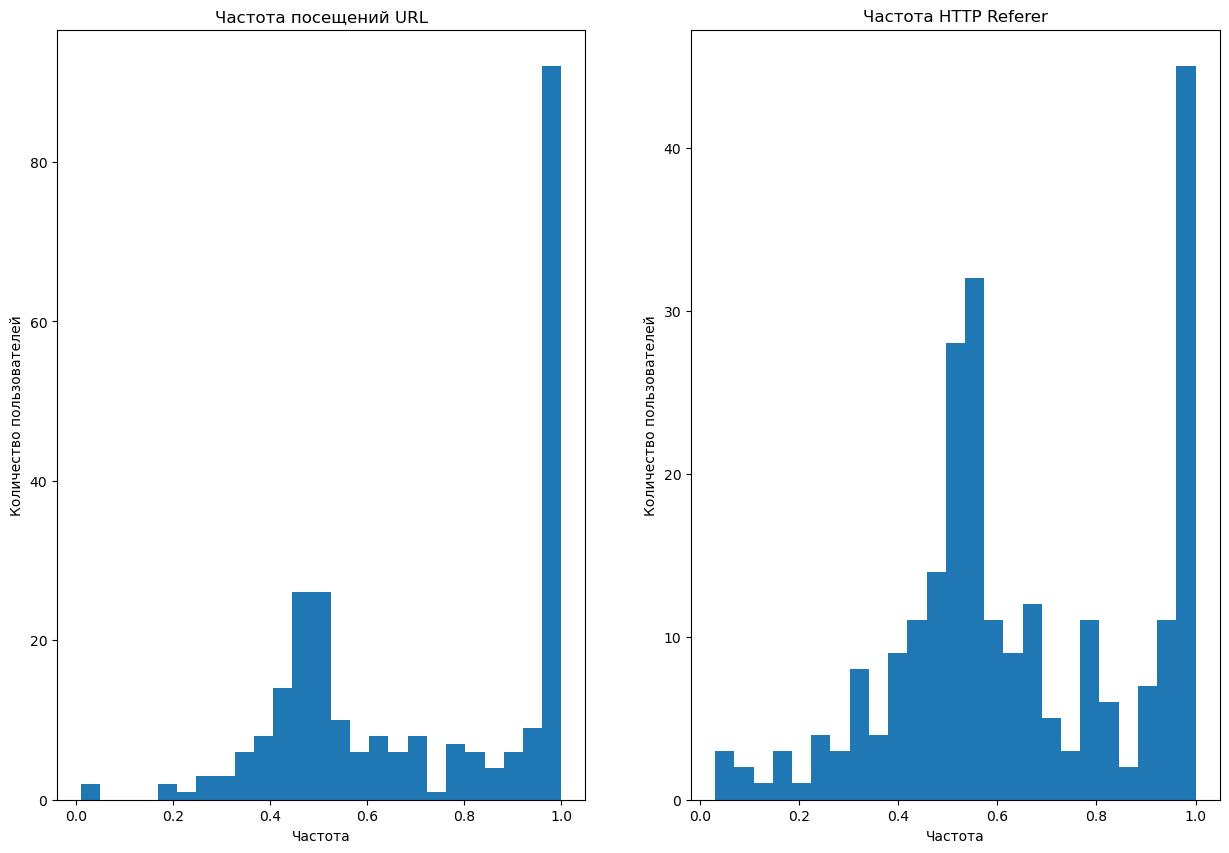

In [26]:
fig,axs = plt.subplots(1,2, figsize = (15,10))
axs[0].hist(big_df['uri','freq']/big_df['uri','count'],bins=25)
axs[0].set_title('Частота посещений URL')
axs[0].set_xlabel('Частота')
axs[0].set_ylabel('Количество пользователей')
axs[1].hist(big_df['http_referer','freq']/big_df['http_referer','count'],bins=25)
axs[1].set_title('Частота HTTP Referer')
axs[1].set_xlabel('Частота')
axs[1].set_ylabel('Количество пользователей');

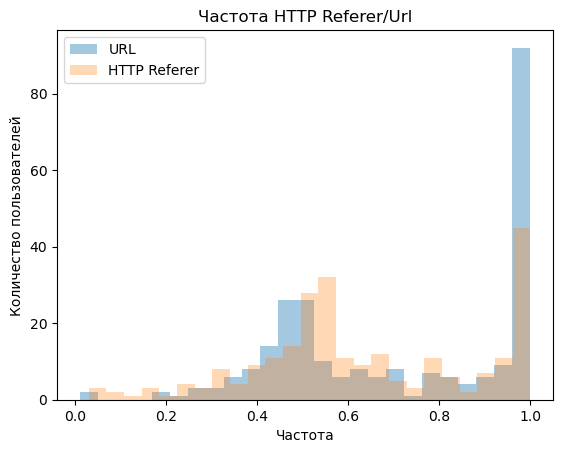

In [27]:
plt.hist(big_df['uri','freq']/big_df['uri','count'],bins=25,alpha=0.4)
plt.hist(big_df['http_referer','freq']/big_df['http_referer','count'],bins=25,alpha=0.3)
plt.title('Частота HTTP Referer/Url')
plt.xlabel('Частота')
plt.ylabel('Количество пользователей')
plt.legend(['URL','HTTP Referer']);

In [28]:
big_df[(big_df['uri','unique']==1)&(big_df['http_referer','unique']<=1)]['http_referer','top'].value_counts()

(http_referer, top)
https://www.drom.ru/              29
https://yandex.ru/                 3
https://www.drom.ru/reviews/       2
https://newadmin.drom.ru/          1
https://auto.drom.ru/region25/     1
Name: count, dtype: int64

In [29]:
big_df[(big_df['uri','unique']==1)&(big_df['http_referer','unique']<=1)]['uri','top'].value_counts()

(uri, top)
/reviews/           42
/reviews/suzuki/     1
Name: count, dtype: int64

[Text(0, 0, '2024-03-11'),
 Text(1, 0, '2024-03-12'),
 Text(2, 0, '2024-03-13'),
 Text(3, 0, '2024-03-14'),
 Text(4, 0, '2024-03-15'),
 Text(5, 0, '2024-03-16'),
 Text(6, 0, '2024-03-17')]

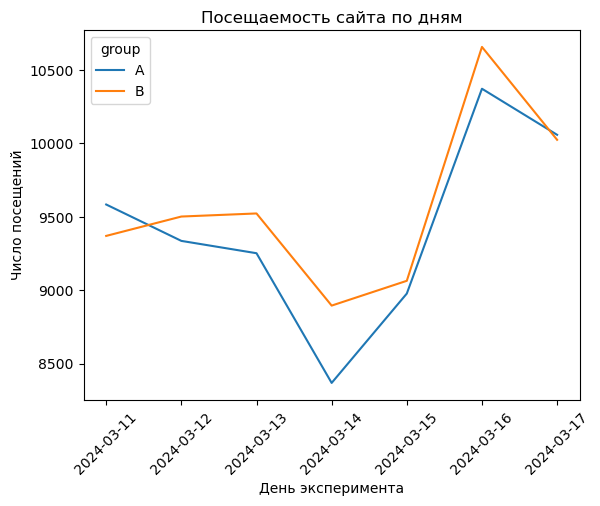

In [114]:
gg=sns.lineplot(data=df.groupby(['group','dt'])['uri'].count().reset_index(),x='dt',y='uri',hue='group')
plt.title('Посещаемость сайта по дням')
plt.xlabel("День эксперимента")
plt.ylabel('Число посещений')
gg.set_xticklabels(gg.get_xticklabels(),rotation=45)

После изучения выбросов могу предположить, что это не боты и стоит опираться на результаты теста по общей выборке
число посещений группы Б увеличилось

## Ретеншен

In [116]:
first_enter = df.groupby('uuid')['dt'].min().reset_index()
first_enter.head()

,uuid,dt
0,00006E7DDF02C18FBE3A24B17AAC193B1,2024-03-13
1,0001E7038542ECB72EE4CD8E82538D167,2024-03-16
2,0003BDB128A710D0A86730A4D329C78B7,2024-03-14
3,0006751C7CBBB65C40FBB7C19B42ABFB4,2024-03-13
4,00067C459C048CF474115DD5BE5CF1255,2024-03-11


In [117]:
first_enter.columns = ['uuid','first_enter_dt']
df_with_first_enter = pd.merge(df, first_enter, on='uuid')
df_with_first_enter.head()

,dt,tme,host,uri,uuid,http_referer,group,first_enter_dt
0,2024-03-11,2024-03-11 02:24:05,www.drom.ru,/reviews/mazda/,2DFFCEFAE7058EADEC2146CC6909D61F9,NaN,B,2024-03-11
1,2024-03-11,2024-03-11 08:32:45,www.drom.ru,/reviews/mazda/,AF07979ACDDE0FB05AC0BA043618C1C01,NaN,B,2024-03-11
2,2024-03-11,2024-03-10 14:21:12,www.drom.ru,/reviews/,B09421E2D5E29714C394D2408D0DF9FE1,NaN,B,2024-03-11
3,2024-03-11,2024-03-10 22:34:45,www.drom.ru,/reviews/mazda/,17D10C2F9AA72622A403E5BFB5EAA7556,NaN,A,2024-03-11
4,2024-03-11,2024-03-11 05:35:15,www.drom.ru,/reviews/toyota/,5966060A2DE813BA4F89F6BD935A94717,NaN,B,2024-03-11


In [118]:
df_with_first_enter['next_dt'] = pd.to_datetime(df_with_first_enter['first_enter_dt']) + pd.Timedelta(days=1)
df_with_first_enter.head()

,dt,tme,host,uri,uuid,http_referer,group,first_enter_dt,next_dt
0,2024-03-11,2024-03-11 02:24:05,www.drom.ru,/reviews/mazda/,2DFFCEFAE7058EADEC2146CC6909D61F9,NaN,B,2024-03-11,2024-03-12
1,2024-03-11,2024-03-11 08:32:45,www.drom.ru,/reviews/mazda/,AF07979ACDDE0FB05AC0BA043618C1C01,NaN,B,2024-03-11,2024-03-12
2,2024-03-11,2024-03-10 14:21:12,www.drom.ru,/reviews/,B09421E2D5E29714C394D2408D0DF9FE1,NaN,B,2024-03-11,2024-03-12
3,2024-03-11,2024-03-10 22:34:45,www.drom.ru,/reviews/mazda/,17D10C2F9AA72622A403E5BFB5EAA7556,NaN,A,2024-03-11,2024-03-12
4,2024-03-11,2024-03-11 05:35:15,www.drom.ru,/reviews/toyota/,5966060A2DE813BA4F89F6BD935A94717,NaN,B,2024-03-11,2024-03-12


In [119]:
returned_next_day = df_with_first_enter[df_with_first_enter.dt==df_with_first_enter.next_dt]
returned_next_day.head()

,dt,tme,host,uri,uuid,http_referer,group,first_enter_dt,next_dt
34,2024-03-12,2024-03-11 14:09:01,www.drom.ru,/reviews/,E882E1B7F3F6967249E8BE02F33208F59,https://www.drom.ru/,B,2024-03-11,2024-03-12
35,2024-03-12,2024-03-12 10:12:11,www.drom.ru,/reviews/,E882E1B7F3F6967249E8BE02F33208F59,https://www.drom.ru/,B,2024-03-11,2024-03-12
95,2024-03-13,2024-03-13 03:39:05,www.drom.ru,/reviews/mazda/,F68952AEE2411D9936A3F4D031D31C7A3,https://www.drom.ru/reviews/,B,2024-03-12,2024-03-13
96,2024-03-13,2024-03-13 03:38:58,www.drom.ru,/reviews/,F68952AEE2411D9936A3F4D031D31C7A3,https://www.google.com/,B,2024-03-12,2024-03-13
127,2024-03-14,2024-03-13 14:05:03,www.drom.ru,/reviews/,99E099DC217AEEB8E0A8513B3A23DCCE2,https://www.drom.ru/catalog/cheryexeed/lx/g_20...,A,2024-03-13,2024-03-14


In [120]:
# подсчёт ретеншен 2 дня общий
returned_next_day.groupby('group')['uuid'].nunique() / df_with_first_enter.groupby('group')['uuid'].nunique() * 100

group
A    2.370834
B    2.442944
Name: uuid, dtype: float64

In [121]:
# отдельно
returned_next_day.groupby('group')['uuid'].nunique()

group
A    954
B    973
Name: uuid, dtype: int64

In [122]:
df_with_first_enter.groupby('group')['uuid'].nunique()

group
A    40239
B    39829
Name: uuid, dtype: int64

In [123]:

# Общее количество пользователей в каждой группе
total_users_A = 40239
total_users_B = 39829

# Количество пользователей, вернувшихся на второй день в каждой группе
returned_users_A = 954
returned_users_B = 973

# Проведение биномиального теста
p_value = stats.binom_test([returned_users_A, returned_users_B], n=[total_users_A, total_users_B], alternative='less')

print("Всего в группе А:", total_users_A)
print("Всего в группе B:", total_users_B)
print("Вернулись на второй день в группе А:", returned_users_A)
print("Вернулись на второй день в группе B:", returned_users_B)
print("P-value:", p_value)

Всего в группе А: 40239
Всего в группе B: 39829
Вернулись на второй день в группе А: 954
Вернулись на второй день в группе B: 973
P-value: 0.34089183990715816


PV больше 0.05, мы не можем отвергуть гиппотезу А>=B

In [130]:
import math
# Данные
total_users_A = 40239
total_users_B = 39829
returned_users_A = 954
returned_users_B = 973

# Пропорции
p_A = returned_users_A / total_users_A
p_B = returned_users_B / total_users_B

# Критическое значение для 95% доверительного интервала
z = 1.96

# Доверительный интервал для группы A
ci_lower_A = p_A - z * math.sqrt((p_A * (1 - p_A)) / total_users_A)
ci_upper_A = p_A + z * math.sqrt((p_A * (1 - p_A)) / total_users_A)

# Доверительный интервал для группы B
ci_lower_B = p_B - z * math.sqrt((p_B * (1 - p_B)) / total_users_B)
ci_upper_B = p_B + z * math.sqrt((p_B * (1 - p_B)) / total_users_B)

print(f"Группа A: пропорция = {p_A:.4f}, 95% доверительный интервал = ({ci_lower_A:.4f}, {ci_upper_A:.4f})")
print(f"Группа B: пропорция = {p_B:.4f}, 95% доверительный интервал = ({ci_lower_B:.4f}, {ci_upper_B:.4f})")


Группа A: пропорция = 0.0237, 95% доверительный интервал = (0.0222, 0.0252)
Группа B: пропорция = 0.0244, 95% доверительный интервал = (0.0229, 0.0259)


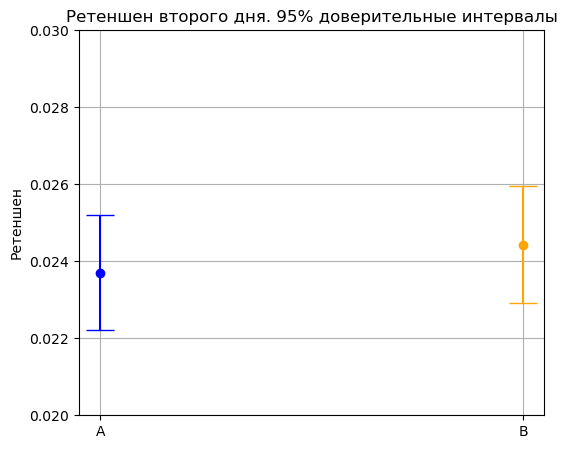

In [149]:
groups = ['A', 'B']
proportions = [p_A, p_B]
ci_lowers = [p_A - ci_lower_A, p_B - ci_lower_B]
ci_uppers = [ci_upper_A - p_A, ci_upper_B - p_B]

plt.figure(figsize=(6, 5))

# Построение графика с использованием errorbar
# Отображение первой группы
plt.errorbar(groups[0], proportions[0], 
             yerr=[[ci_lowers[0]], [ci_uppers[0]]], 
             fmt='o', 
             color='blue', 
             capsize=10, 
             ecolor='blue')

# Отображение второй группы
plt.errorbar(groups[1], proportions[1], 
             yerr=[[ci_lowers[1]], [ci_uppers[1]]], 
             fmt='o', 
             color='orange', 
             capsize=10, 
             ecolor='orange')

plt.ylim(0.02, 0.03)
plt.ylabel('Ретеншен')
plt.title('Ретеншен второго дня. 95% доверительные интервалы')
plt.grid()
plt.show()

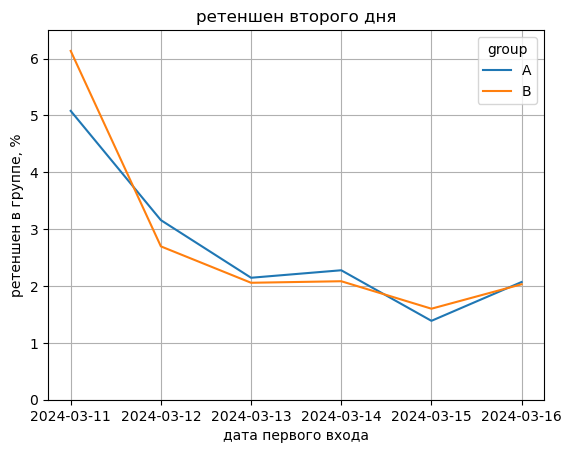

In [150]:
# анализ ретеншен по дням
days = returned_next_day.groupby(['group','first_enter_dt'])['uuid'].nunique() / df_with_first_enter.groupby(['group','first_enter_dt'])['uuid'].nunique() * 100
days.reset_index()
temp =sns.lineplot(data=days.reset_index(),x='first_enter_dt',y='uuid',hue='group')
plt.grid()
plt.ylim([0,6.5])
temp.set(xlabel='дата первого входа',ylabel='ретеншен в группе, %',title='ретеншен второго дня');

## Конверсия

In [151]:
# конверсия
rewiews_uri = df_with_first_enter[df_with_first_enter['uri'] == '/reviews/']
rewiews_host = df_with_first_enter[(df_with_first_enter['http_referer'] == 'https://www.drom.ru/reviews/')]
conv = rewiews_host.groupby('group')['uuid'].nunique() / rewiews_uri.groupby('group')['uuid'].nunique() * 100
conv

group
A    40.291116
B    39.435557
Name: uuid, dtype: float64

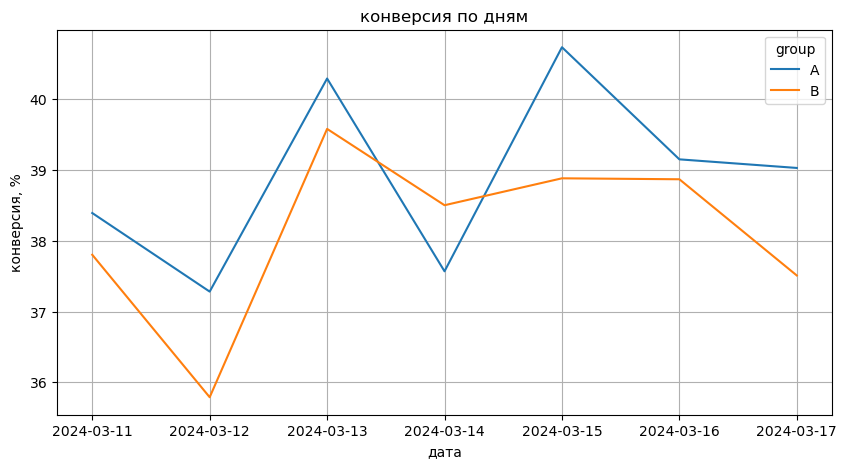

In [152]:
# график конверсии по дням
conv_by_day = rewiews_host.groupby(['group','dt'])['uuid'].nunique() / rewiews_uri.groupby(['group','dt'])['uuid'].nunique() * 100
plt.figure(figsize=(10,5))
temp =sns.lineplot(data=conv_by_day.reset_index(),x='dt',y='uuid',hue='group')
plt.grid()
temp.set(xlabel='дата',ylabel='конверсия, %',title='конверсия по дням');

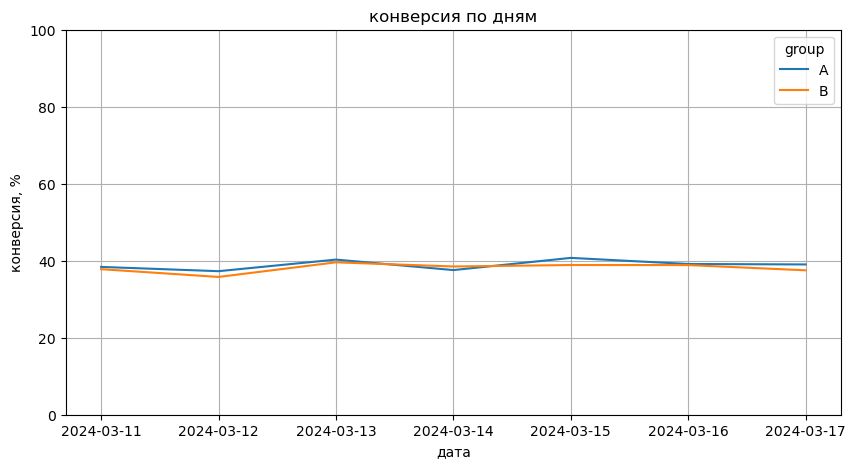

In [50]:
# график конверсии по дням реальный масштаб
conv_by_day = rewiews_host.groupby(['group','dt'])['uuid'].nunique() / rewiews_uri.groupby(['group','dt'])['uuid'].nunique() * 100
plt.figure(figsize=(10,5))
temp =sns.lineplot(data=conv_by_day.reset_index(),x='dt',y='uuid',hue='group')
plt.grid()
plt.ylim([0,100])
temp.set(xlabel='дата',ylabel='конверсия, %',title='конверсия по дням');

In [52]:
rewiews_host.groupby('group')['uuid'].nunique()

group
A    5370
B    5226
Name: uuid, dtype: int64

In [55]:
rewiews_uri.groupby(['group'])['uuid'].nunique()

group
A    13328
B    13252
Name: uuid, dtype: int64

In [161]:
# Общее количество пользователей в каждой группе
total_users_A = 13328
total_users_B = 13252

# Количество пользователей, совершивших целевое действие
conv_users_A = 5370
conv_users_B = 5226

# Проведение биномиального теста
p_value = stats.binom_test([conv_users_A, conv_users_B], n=[total_users_A, total_users_B], alternative='greater')

print("Всего в группе А:", total_users_A)
print("Всего в группе B:", total_users_B)
print("Перешли по ссылке в группе A:", conv_users_A)
print("Перешли по ссылке в группе B:", conv_users_B)
print("P-value:", p_value)

Всего в группе А: 13328
Всего в группе B: 13252
Перешли по ссылке в группе A: 5370
Перешли по ссылке в группе B: 5226
P-value: 0.0823842867004142


In [162]:
import math

total_users_A = 13328
total_users_B = 13252

# Количество пользователей, совершивших целевое действие
conv_users_A = 5370
conv_users_B = 5226

# Пропорции
p_A = conv_users_A / total_users_A
p_B = conv_users_B / total_users_B

# Критическое значение для 95% доверительного интервала
z = 1.96

# Доверительный интервал для группы A
ci_lower_A = p_A - z * math.sqrt((p_A * (1 - p_A)) / total_users_A)
ci_upper_A = p_A + z * math.sqrt((p_A * (1 - p_A)) / total_users_A)

# Доверительный интервал для группы B
ci_lower_B = p_B - z * math.sqrt((p_B * (1 - p_B)) / total_users_B)
ci_upper_B = p_B + z * math.sqrt((p_B * (1 - p_B)) / total_users_B)

print(f"Группа A: пропорция = {p_A:.4f}, 95% доверительный интервал = ({ci_lower_A:.4f}, {ci_upper_A:.4f})")
print(f"Группа B: пропорция = {p_B:.4f}, 95% доверительный интервал = ({ci_lower_B:.4f}, {ci_upper_B:.4f})")

Группа A: пропорция = 0.4029, 95% доверительный интервал = (0.3946, 0.4112)
Группа B: пропорция = 0.3944, 95% доверительный интервал = (0.3860, 0.4027)


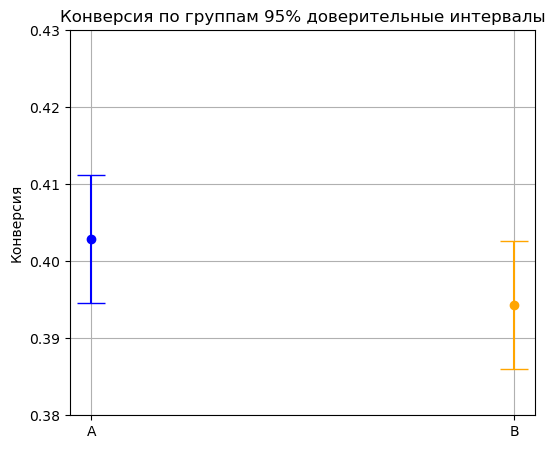

In [163]:
groups = ['A', 'B']
proportions = [p_A, p_B]
ci_lowers = [p_A - ci_lower_A, p_B - ci_lower_B]
ci_uppers = [ci_upper_A - p_A, ci_upper_B - p_B]

plt.figure(figsize=(6, 5))

# Построение графика с использованием errorbar
# Отображение первой группы
plt.errorbar(groups[0], proportions[0], 
             yerr=[[ci_lowers[0]], [ci_uppers[0]]], 
             fmt='o', 
             color='blue', 
             capsize=10, 
             ecolor='blue')

# Отображение второй группы
plt.errorbar(groups[1], proportions[1], 
             yerr=[[ci_lowers[1]], [ci_uppers[1]]], 
             fmt='o', 
             color='orange', 
             capsize=10, 
             ecolor='orange')

plt.ylim(0.38, 0.43)
plt.ylabel('Конверсия')
plt.title('Конверсия по группам 95% доверительные интервалы')
plt.grid()
plt.show()

In [164]:
rewiews_uri

,dt,tme,host,uri,uuid,http_referer,group,first_enter_dt,next_dt
2,2024-03-11,2024-03-10 14:21:12,www.drom.ru,/reviews/,B09421E2D5E29714C394D2408D0DF9FE1,NaN,B,2024-03-11,2024-03-12
5,2024-03-16,2024-03-16 04:11:11,www.drom.ru,/reviews/,2CB8B477564A3C10195DD32CAAC9FF137,NaN,B,2024-03-16,2024-03-17
6,2024-03-14,2024-03-14 08:56:20,www.drom.ru,/reviews/,E882E1B7F3F6967249E8BE02F33208F59,https://www.drom.ru/,B,2024-03-11,2024-03-12
7,2024-03-14,2024-03-14 08:54:30,www.drom.ru,/reviews/,E882E1B7F3F6967249E8BE02F33208F59,https://www.drom.ru/,B,2024-03-11,2024-03-12
8,2024-03-14,2024-03-14 10:22:43,www.drom.ru,/reviews/,E882E1B7F3F6967249E8BE02F33208F59,https://www.drom.ru/,B,2024-03-11,2024-03-12
...,...,...,...,...,...,...,...,...,...
132969,2024-03-14,2024-03-13 22:00:36,www.drom.ru,/reviews/,C6FE5E2CD90F8AFB2729336B0A755C592,https://www.google.com,A,2024-03-14,2024-03-15
132971,2024-03-14,2024-03-13 18:03:31,www.drom.ru,/reviews/,6F136BC7FD66682C73685C0909A7CA291,https://www.drom.ru/reviews/roewe/rx5/,B,2024-03-14,2024-03-15
132972,2024-03-14,2024-03-13 18:04:26,www.drom.ru,/reviews/,6F136BC7FD66682C73685C0909A7CA291,https://www.drom.ru/reviews/roewe/rx5/,B,2024-03-14,2024-03-15
132979,2024-03-14,2024-03-13 17:13:43,www.drom.ru,/reviews/,5FFC801C08A185581D85E8920BAE995F0,https://www.drom.ru/,A,2024-03-14,2024-03-15


In [165]:
# коверсия на пользователя
conv_uuid = (rewiews_host.groupby(['group','uuid'])['uri'].count() / rewiews_uri.groupby(['group','uuid'])['uri'].count()).reset_index()
conv_uuid.groupby('group')['uri'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,5276.0,1.039111,0.542508,0.020619,1.0,1.0,1.0,9.000000
B,5149.0,1.040092,0.553692,0.006780,1.0,1.0,1.0,18.333333


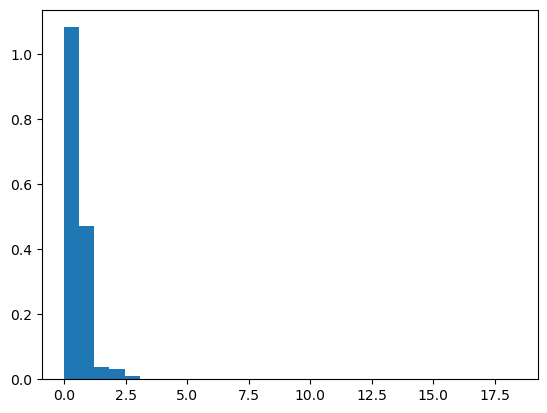

In [175]:
plt.hist(conv_uuid['uri'].fillna(0),bins=30,density=True);

In [179]:
grA = conv_uuid[conv_uuid['group'] == 'A']['uri'].fillna(0)
grB = conv_uuid[conv_uuid['group'] == 'B']['uri'].fillna(0)
stats.ttest_ind(grA,grB,alternative='greater')

TtestResult(statistic=0.8920636742952419, pvalue=0.18618341424337476, df=26749.0)

In [159]:
conv_uuid = conv_uuid[conv_uuid.uuid.isin(rewiews_uri.uuid)]

In [150]:
rewiews_uri[rewiews_uri.uuid=='FFEE8A53BC7A71413C7B556AD4825A465']

,dt,tme,host,uri,uuid,http_referer,group,first_enter_dt,next_dt
110443,2024-03-15,2024-03-15 10:11:56,www.drom.ru,/reviews/,FFEE8A53BC7A71413C7B556AD4825A465,https://www.drom.ru/reviews/lada/priora/1305685/,B,2024-03-15,2024-03-16
